# Data preprocessing

## emotion label + path to file

In [31]:
#!/home/judehey/miniconda3/envs/myenv/bin/python

import pandas as pd
import numpy as np
import os

pathToData="../data/tess/"
imgsPath="../imgs/tess/"
modelsPath="../models/tess/"

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over utterances in speech folder
    for folder in os.listdir(path):
        for file in os.listdir(path + folder):
            emotion.append(file.split("_")[2].split(".")[0])
            file_path.append(path + folder + "/" + file)
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({"ps": "surprised"})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/tess/oaf/OAF_pike_sad.wav,sad
1,../data/tess/oaf/OAF_bought_disgust.wav,disgust
2,../data/tess/oaf/OAF_gin_sad.wav,sad
3,../data/tess/oaf/OAF_learn_angry.wav,angry
4,../data/tess/oaf/OAF_moon_neutral.wav,neutral
...,...,...
2795,../data/tess/yaf/YAF_cause_fear.wav,fear
2796,../data/tess/yaf/YAF_hate_ps.wav,surprised
2797,../data/tess/yaf/YAF_gun_happy.wav,happy
2798,../data/tess/yaf/YAF_chair_disgust.wav,disgust


# Plots

## class distribution

['sad' 'disgust' 'angry' 'neutral' 'fear' 'happy' 'surprised']


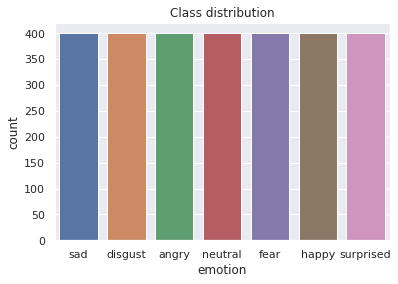

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
sns.set_theme(style='darkgrid')
sns.countplot(x = 'emotion', data = df)
plt.title('Class distribution')
plt.savefig(imgsPath + 'class_distribution.png')
plt.show()

## waveform

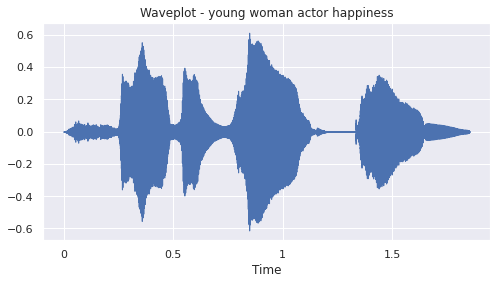

In [33]:
import librosa.display

# waveplot
wavf, sr = librosa.load('../data/tess/yaf/YAF_gun_happy.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - young woman actor happiness')
plt.savefig(imgsPath + 'waveplot_yaf_happiness.png')
plt.show()

## log-mel spectrogram

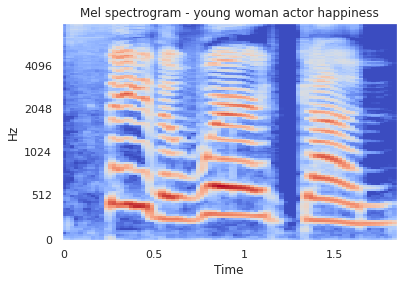

In [34]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - young woman actor happiness')
plt.savefig(imgsPath + 'mel_spec_yaf_happiness.png')
plt.show()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [35]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", duration=_duration, sr=sampleRate)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 2, 44100)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,163,164,165,166,167,168,169,170,171,172
0,sad,-44.866684,-42.563484,-42.934090,-42.198429,-38.585060,-37.314648,-39.344276,-39.559017,-38.614834,...,-41.979794,-38.103256,-35.165031,-30.712734,-25.250000,-21.929203,-19.830929,-19.868361,-22.233919,-21.251535
1,disgust,-41.202820,-38.517208,-37.521523,-35.928848,-36.701500,-37.414253,-36.393902,-33.882385,-32.767769,...,-20.967327,-22.963118,-22.885572,-22.221870,-23.507053,-24.068279,-25.479784,-24.551914,-20.904539,-16.470636
2,sad,-44.523106,-41.317688,-38.223133,-37.148476,-35.793209,-36.431770,-35.850277,-36.279404,-36.554703,...,-37.707291,-39.314594,-38.339470,-38.279835,-38.296024,-39.444401,-39.700020,-40.861137,-39.896214,-38.872395
3,angry,-41.129044,-41.145790,-40.203060,-40.004387,-39.338234,-38.796188,-36.842579,-37.031277,-36.232571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,neutral,-43.564331,-43.538578,-43.997803,-43.378044,-42.618168,-40.774433,-39.563217,-39.384590,-41.079617,...,-26.839230,-26.929281,-27.145792,-26.891811,-26.995079,-26.535362,-26.693199,-27.490786,-23.562895,-18.484276


# Data split

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
1957 -36.305271 -36.789738 -36.425220 -34.747608 -35.367222 -36.745964   
1105 -40.173527 -41.522141 -42.365028 -39.217091 -35.474632 -35.014355   
254  -43.793388 -43.241306 -43.019321 -41.574070 -40.106453 -35.029846   
2592 -32.160595 -29.258410 -23.278524 -22.255568 -26.362617 -29.601513   
1179 -31.665293 -35.141491 -42.677780 -44.319191 -46.104473 -45.569675   

            6          7          8          9    ...        163        164  \
1957 -36.117542 -36.514889 -36.810520 -36.554073  ... -36.101200 -39.634762   
1105 -34.125809 -33.744308 -32.054882 -32.173038  ...   0.000000   0.000000   
254  -33.976143 -34.539223 -33.108162 -34.407253  ... -46.415386 -39.463905   
2592 -29.792355 -33.346142 -32.624657 -30.397259  ... -27.827576 -29.221291   
1179 -42.089725 -39.481453 -39.381378 -37.650951  ... -26.674839 -26.402981   

            165        166        167        168        169        170  \
1957  

# Data preprocessing

In [37]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

(2240,)
(560,)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']
(2240, 173, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(7, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 164, 64)           704       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 155, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 128)           163968    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 128)           

# Model training and export

2022-04-04 12:22:16.634798: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 533.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-04 12:22:16.645709: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 169.62MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.61964, saving model to ../models/tess/model_1_CNN


2022-04-04 12:22:17.014244: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/tess/model_1_CNN/assets

Epoch 00002: val_accuracy improved from 0.61964 to 0.81071, saving model to ../models/tess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/tess/model_1_CNN/assets

Epoch 00003: val_accuracy improved from 0.81071 to 0.86786, saving model to ../models/tess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/tess/model_1_CNN/assets

Epoch 00004: val_accuracy did not improve from 0.86786

Epoch 00005: val_accuracy improved from 0.86786 to 0.90000, saving model to ../models/tess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/tess/model_1_CNN/assets

Epoch 00006: val_accuracy did not improve from 0.90000

Epoch 00007: val_accuracy improved from 0.90000 to 0.90357, saving model to ../models/tess/model_1_CNN
INFO:tensorflow:Assets written to: ../models/tess/model_1_CNN/assets

Epoch 00008: val_accuracy did not improve from 0.90357

Epoch 00009: val_accuracy improved from 0.90357 to 0.90536, saving mod

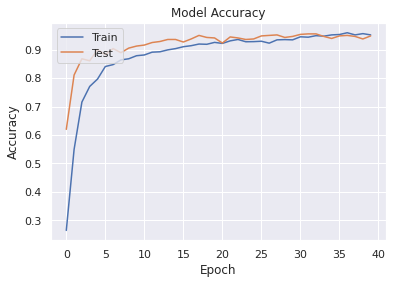

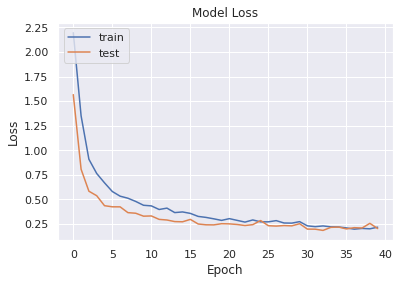

In [39]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint = ModelCheckpoint(modelsPath + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [40]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

18/18 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9482
Loss of the model is -  0.2030697613954544
18/18 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9482
Accuracy of the model is -  94.82142925262451 %


In [41]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,happy,happy
2,neutral,neutral
3,surprised,surprised
4,happy,happy
5,sad,sad
6,sad,neutral
7,fear,fear
8,surprised,surprised
9,surprised,surprised


## confusion matrix

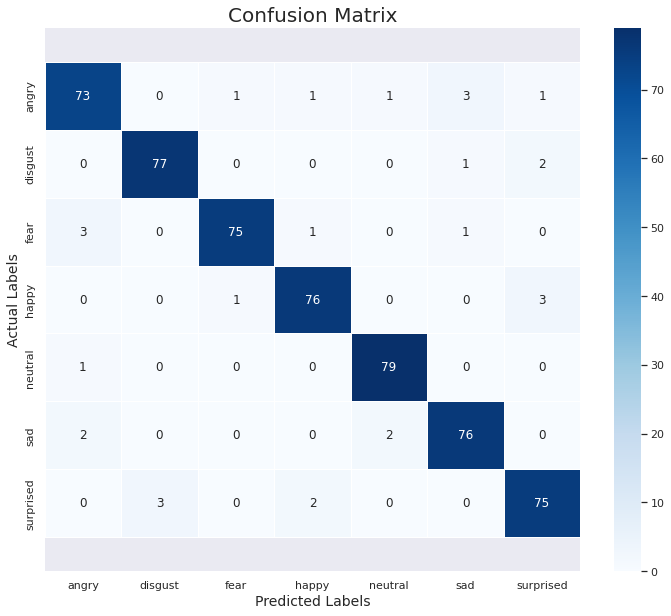

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [44]:
print(classification_report(actual, predictions, target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.92      0.91      0.92        80
     disgust       0.96      0.96      0.96        80
        fear       0.97      0.94      0.96        80
       happy       0.95      0.95      0.95        80
     neutral       0.96      0.99      0.98        80
         sad       0.94      0.95      0.94        80
   surprised       0.93      0.94      0.93        80

    accuracy                           0.95       560
   macro avg       0.95      0.95      0.95       560
weighted avg       0.95      0.95      0.95       560

